# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:cores-oracle.run1",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10.",
                "1-11.",
                "1-15.",
                "1-16.",
                "1-17.",
                "1-18.",
                "1-19.",
                "10-4.",
                "10-7.",
                "11-1.",
                "11-14.",
                "11-17.",
                "11-20.",
                "11-7.",
                "13-20.",
                "13-8.",
                "14-10.",
                "14-11.",
                "14-14.",
                "14-7.",
                "15-1.",
                "15-20.",
                "16-1.",
                "16-16.",
                "17-10.",
                "17-11.",
                "17-2.",
                "19-1.",
                "19-16.",
                "19-19.",
                "19-20.",
                "19-3.",
                "2-10.",
                "2-11.",
                "2-17.",
                "2-18.",
                "2-20.",
                "2-3.",
                "2-4.",
                "2-5.",
                "2-6.",
                "2-7.",
                "2-8.",
                "3-13.",
                "3-18.",
                "3-3.",
                "4-1.",
                "4-10.",
                "4-11.",
                "4-19.",
                "5-5.",
                "6-15.",
                "7-10.",
                "7-14.",
                "8-18.",
                "8-20.",
                "8-3.",
                "8-8.",
            ],
            "domains": [1, 2, 3, 4, 5],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/cores.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "CORES_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
    ],
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_44', 'ORACLE.run1_38', 'ORACLE.run1_26', 'ORACLE.run1_32', 'ORACLE.run1_8', 'ORACLE.run1_14', 'ORACLE.run1_50', 'ORACLE.run1_20'}


{'CORES_3', 'CORES_2', 'CORES_5', 'CORES_1', 'CORES_4'}


tensor([[[ 1.3646,  0.2454,  1.0112,  ..., -0.3043, -0.9228, -0.2945],
         [ 0.3142,  0.4614, -0.0393,  ...,  1.2566,  0.2552, -1.2762]],

        [[ 0.6683,  1.0614, -1.4840,  ..., -1.8182, -0.5602,  1.0319],
         [ 0.5995,  0.5504, -0.1671,  ..., -1.1990, -0.4226, -0.2260]],

        [[-0.8064, -0.1854,  0.7508,  ...,  0.1761, -0.2781, -0.1946],
         [ 0.5098,  0.6488,  0.8527,  ..., -0.2410,  0.8620, -1.2513]],

        ...,

        [[ 0.5589, -0.2290, -1.0078,  ..., -0.1191, -0.7604, -1.4933],
         [ 0.0550,  0.1741,  0.8795,  ...,  0.8429, -0.1283,  1.2826]],

        [[ 0.3345,  0.6504, -0.6875,  ...,  2.0905,  1.3101,  0.4460],
         [ 0.7433,  0.2137, -0.3066,  ...,  1.0313,  0.4738,  0.6132]],

        [[ 0.2057, -0.5544, -1.2518,  ..., -0.3577,  0.7153,  1.0730],
         [ 0.4381, -0.7600, -1.4396,  ...,  0.3666, -0.7690,  1.5826]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 33600], examples_per_second: 6.5662, train_label_loss: 2.7620, 


epoch: 1, [batch: 3360 / 33600], examples_per_second: 3841.1638, train_label_loss: 2.0336, 


epoch: 1, [batch: 6720 / 33600], examples_per_second: 4210.4836, train_label_loss: 0.8808, 


epoch: 1, [batch: 10080 / 33600], examples_per_second: 3921.6984, train_label_loss: 0.6683, 


epoch: 1, [batch: 13440 / 33600], examples_per_second: 3995.6604, train_label_loss: 1.2099, 


epoch: 1, [batch: 16800 / 33600], examples_per_second: 4061.5704, train_label_loss: 0.9112, 


epoch: 1, [batch: 20160 / 33600], examples_per_second: 3880.0766, train_label_loss: 0.5078, 


epoch: 1, [batch: 23520 / 33600], examples_per_second: 4121.1568, train_label_loss: 0.4631, 


epoch: 1, [batch: 26880 / 33600], examples_per_second: 3981.4448, train_label_loss: 0.6169, 


epoch: 1, [batch: 30240 / 33600], examples_per_second: 4099.6558, train_label_loss: 1.4571, 


epoch: 1, source_val_acc_label: 0.6357, target_val_acc_label: 0.9646, source_val_label_loss: 1.0081, target_val_label_loss: 0.1372, 


New best


epoch: 2, [batch: 1 / 33600], examples_per_second: 1.0229, train_label_loss: 0.7598, 


epoch: 2, [batch: 3360 / 33600], examples_per_second: 3961.5304, train_label_loss: 0.5723, 


epoch: 2, [batch: 6720 / 33600], examples_per_second: 3953.9784, train_label_loss: 1.3428, 


epoch: 2, [batch: 10080 / 33600], examples_per_second: 4134.1832, train_label_loss: 0.6241, 


epoch: 2, [batch: 13440 / 33600], examples_per_second: 3884.3816, train_label_loss: 0.4782, 


epoch: 2, [batch: 16800 / 33600], examples_per_second: 4249.8555, train_label_loss: 0.7703, 


epoch: 2, [batch: 20160 / 33600], examples_per_second: 3984.8414, train_label_loss: 1.0998, 


epoch: 2, [batch: 23520 / 33600], examples_per_second: 4008.8830, train_label_loss: 1.1130, 


epoch: 2, [batch: 26880 / 33600], examples_per_second: 4163.8965, train_label_loss: 1.1018, 


epoch: 2, [batch: 30240 / 33600], examples_per_second: 4043.6336, train_label_loss: 1.1910, 


epoch: 2, source_val_acc_label: 0.6771, target_val_acc_label: 0.9650, source_val_label_loss: 0.8555, target_val_label_loss: 0.1745, 


New best


epoch: 3, [batch: 1 / 33600], examples_per_second: 1.0433, train_label_loss: 0.5992, 


epoch: 3, [batch: 3360 / 33600], examples_per_second: 4321.1472, train_label_loss: 1.1362, 


epoch: 3, [batch: 6720 / 33600], examples_per_second: 4007.8065, train_label_loss: 1.0752, 


epoch: 3, [batch: 10080 / 33600], examples_per_second: 3964.3666, train_label_loss: 0.6152, 


epoch: 3, [batch: 13440 / 33600], examples_per_second: 4090.6858, train_label_loss: 0.5232, 


epoch: 3, [batch: 16800 / 33600], examples_per_second: 3917.1725, train_label_loss: 0.7069, 


epoch: 3, [batch: 20160 / 33600], examples_per_second: 4236.9215, train_label_loss: 0.9676, 


epoch: 3, [batch: 23520 / 33600], examples_per_second: 3844.7535, train_label_loss: 0.9414, 


epoch: 3, [batch: 26880 / 33600], examples_per_second: 4036.7072, train_label_loss: 0.9451, 


epoch: 3, [batch: 30240 / 33600], examples_per_second: 4055.4941, train_label_loss: 0.5931, 


epoch: 3, source_val_acc_label: 0.7061, target_val_acc_label: 0.9730, source_val_label_loss: 0.7965, target_val_label_loss: 0.1910, 


New best


epoch: 4, [batch: 1 / 33600], examples_per_second: 1.0660, train_label_loss: 0.3726, 


epoch: 4, [batch: 3360 / 33600], examples_per_second: 3934.4697, train_label_loss: 0.5024, 


epoch: 4, [batch: 6720 / 33600], examples_per_second: 4424.4752, train_label_loss: 1.1172, 


epoch: 4, [batch: 10080 / 33600], examples_per_second: 4505.9895, train_label_loss: 0.8416, 


epoch: 4, [batch: 13440 / 33600], examples_per_second: 5060.7871, train_label_loss: 0.5112, 


epoch: 4, [batch: 16800 / 33600], examples_per_second: 5230.6364, train_label_loss: 1.2326, 


epoch: 4, [batch: 20160 / 33600], examples_per_second: 4321.3372, train_label_loss: 1.1392, 


epoch: 4, [batch: 23520 / 33600], examples_per_second: 3892.7669, train_label_loss: 0.4427, 


epoch: 4, [batch: 26880 / 33600], examples_per_second: 4298.8225, train_label_loss: 0.6367, 


epoch: 4, [batch: 30240 / 33600], examples_per_second: 3905.8302, train_label_loss: 0.6533, 


epoch: 4, source_val_acc_label: 0.7148, target_val_acc_label: 0.9765, source_val_label_loss: 0.7721, target_val_label_loss: 0.1752, 


New best


epoch: 5, [batch: 1 / 33600], examples_per_second: 1.0499, train_label_loss: 0.5075, 


epoch: 5, [batch: 3360 / 33600], examples_per_second: 4028.8644, train_label_loss: 0.7758, 


epoch: 5, [batch: 6720 / 33600], examples_per_second: 4090.6568, train_label_loss: 0.6491, 


epoch: 5, [batch: 10080 / 33600], examples_per_second: 3938.7441, train_label_loss: 0.4668, 


epoch: 5, [batch: 13440 / 33600], examples_per_second: 4152.1539, train_label_loss: 0.6072, 


epoch: 5, [batch: 16800 / 33600], examples_per_second: 4005.6477, train_label_loss: 0.8717, 


epoch: 5, [batch: 20160 / 33600], examples_per_second: 4067.6539, train_label_loss: 0.6495, 


epoch: 5, [batch: 23520 / 33600], examples_per_second: 4143.1026, train_label_loss: 0.3684, 


epoch: 5, [batch: 26880 / 33600], examples_per_second: 3915.9165, train_label_loss: 0.6973, 


epoch: 5, [batch: 30240 / 33600], examples_per_second: 4160.2285, train_label_loss: 0.5935, 


epoch: 5, source_val_acc_label: 0.7219, target_val_acc_label: 0.9782, source_val_label_loss: 0.7642, target_val_label_loss: 0.1722, 


New best


epoch: 6, [batch: 1 / 33600], examples_per_second: 1.0355, train_label_loss: 0.3960, 


epoch: 6, [batch: 3360 / 33600], examples_per_second: 3939.9600, train_label_loss: 0.6520, 


epoch: 6, [batch: 6720 / 33600], examples_per_second: 4091.6998, train_label_loss: 0.7552, 


epoch: 6, [batch: 10080 / 33600], examples_per_second: 4394.9374, train_label_loss: 1.0837, 


epoch: 6, [batch: 13440 / 33600], examples_per_second: 4619.2755, train_label_loss: 0.6116, 


epoch: 6, [batch: 16800 / 33600], examples_per_second: 4972.4087, train_label_loss: 0.7277, 


epoch: 6, [batch: 20160 / 33600], examples_per_second: 5289.7588, train_label_loss: 0.6334, 


epoch: 6, [batch: 23520 / 33600], examples_per_second: 4627.8931, train_label_loss: 0.3959, 


epoch: 6, [batch: 26880 / 33600], examples_per_second: 4004.8326, train_label_loss: 0.5836, 


epoch: 6, [batch: 30240 / 33600], examples_per_second: 4111.7499, train_label_loss: 0.5489, 


epoch: 6, source_val_acc_label: 0.7263, target_val_acc_label: 0.9808, source_val_label_loss: 0.7647, target_val_label_loss: 0.1693, 


New best


epoch: 7, [batch: 1 / 33600], examples_per_second: 1.0283, train_label_loss: 0.9812, 


epoch: 7, [batch: 3360 / 33600], examples_per_second: 3967.6842, train_label_loss: 0.4911, 


epoch: 7, [batch: 6720 / 33600], examples_per_second: 3915.5642, train_label_loss: 0.3928, 


epoch: 7, [batch: 10080 / 33600], examples_per_second: 4169.3123, train_label_loss: 0.4478, 


epoch: 7, [batch: 13440 / 33600], examples_per_second: 3948.7722, train_label_loss: 0.2845, 


epoch: 7, [batch: 16800 / 33600], examples_per_second: 4240.2004, train_label_loss: 0.6246, 


epoch: 7, [batch: 20160 / 33600], examples_per_second: 4015.1633, train_label_loss: 0.3510, 


epoch: 7, [batch: 23520 / 33600], examples_per_second: 3901.6530, train_label_loss: 0.3014, 


epoch: 7, [batch: 26880 / 33600], examples_per_second: 4326.4192, train_label_loss: 0.5810, 


epoch: 7, [batch: 30240 / 33600], examples_per_second: 4427.4828, train_label_loss: 0.5326, 


epoch: 7, source_val_acc_label: 0.7264, target_val_acc_label: 0.9806, source_val_label_loss: 0.7513, target_val_label_loss: 0.1665, 


epoch: 8, [batch: 1 / 33600], examples_per_second: 1.3231, train_label_loss: 0.2341, 


epoch: 8, [batch: 3360 / 33600], examples_per_second: 4582.5581, train_label_loss: 0.4630, 


epoch: 8, [batch: 6720 / 33600], examples_per_second: 4020.5663, train_label_loss: 0.3781, 


epoch: 8, [batch: 10080 / 33600], examples_per_second: 4087.9345, train_label_loss: 0.8440, 


epoch: 8, [batch: 13440 / 33600], examples_per_second: 4060.2998, train_label_loss: 0.6660, 


epoch: 8, [batch: 16800 / 33600], examples_per_second: 3941.9030, train_label_loss: 0.4194, 


epoch: 8, [batch: 20160 / 33600], examples_per_second: 4137.7333, train_label_loss: 0.7646, 


epoch: 8, [batch: 23520 / 33600], examples_per_second: 3857.1864, train_label_loss: 0.3897, 


epoch: 8, [batch: 26880 / 33600], examples_per_second: 4041.6955, train_label_loss: 0.6363, 


epoch: 8, [batch: 30240 / 33600], examples_per_second: 4087.5710, train_label_loss: 0.3024, 


epoch: 8, source_val_acc_label: 0.7302, target_val_acc_label: 0.9806, source_val_label_loss: 0.7569, target_val_label_loss: 0.1746, 


epoch: 9, [batch: 1 / 33600], examples_per_second: 1.0435, train_label_loss: 0.3206, 


epoch: 9, [batch: 3360 / 33600], examples_per_second: 3946.6526, train_label_loss: 0.3503, 


epoch: 9, [batch: 6720 / 33600], examples_per_second: 4232.9578, train_label_loss: 0.3290, 


epoch: 9, [batch: 10080 / 33600], examples_per_second: 4386.7929, train_label_loss: 0.7160, 


epoch: 9, [batch: 13440 / 33600], examples_per_second: 3039.1232, train_label_loss: 0.4793, 


epoch: 9, [batch: 16800 / 33600], examples_per_second: 5045.6869, train_label_loss: 0.3713, 


epoch: 9, [batch: 20160 / 33600], examples_per_second: 3219.1551, train_label_loss: 0.3835, 


epoch: 9, [batch: 23520 / 33600], examples_per_second: 2974.1840, train_label_loss: 0.4019, 


epoch: 9, [batch: 26880 / 33600], examples_per_second: 3530.1770, train_label_loss: 0.4042, 


epoch: 9, [batch: 30240 / 33600], examples_per_second: 3232.1951, train_label_loss: 0.4803, 


epoch: 9, source_val_acc_label: 0.7283, target_val_acc_label: 0.9808, source_val_label_loss: 0.7754, target_val_label_loss: 0.1750, 


epoch: 10, [batch: 1 / 33600], examples_per_second: 0.8025, train_label_loss: 0.5416, 


epoch: 10, [batch: 3360 / 33600], examples_per_second: 3174.7012, train_label_loss: 0.3729, 


epoch: 10, [batch: 6720 / 33600], examples_per_second: 3159.1728, train_label_loss: 0.2245, 


epoch: 10, [batch: 10080 / 33600], examples_per_second: 3328.5267, train_label_loss: 0.8177, 


epoch: 10, [batch: 13440 / 33600], examples_per_second: 3471.9670, train_label_loss: 0.2709, 


epoch: 10, [batch: 16800 / 33600], examples_per_second: 3012.8403, train_label_loss: 0.4593, 


epoch: 10, [batch: 20160 / 33600], examples_per_second: 3188.8863, train_label_loss: 0.2012, 


epoch: 10, [batch: 23520 / 33600], examples_per_second: 3622.4668, train_label_loss: 0.2304, 


epoch: 10, [batch: 26880 / 33600], examples_per_second: 3027.4018, train_label_loss: 0.2351, 


epoch: 10, [batch: 30240 / 33600], examples_per_second: 3212.0216, train_label_loss: 0.4816, 


epoch: 10, source_val_acc_label: 0.7296, target_val_acc_label: 0.9823, source_val_label_loss: 0.7892, target_val_label_loss: 0.1727, 


New best


epoch: 11, [batch: 1 / 33600], examples_per_second: 0.9879, train_label_loss: 0.4035, 


epoch: 11, [batch: 3360 / 33600], examples_per_second: 3980.6948, train_label_loss: 0.3967, 


epoch: 11, [batch: 6720 / 33600], examples_per_second: 3910.9286, train_label_loss: 0.1708, 


epoch: 11, [batch: 10080 / 33600], examples_per_second: 3458.0623, train_label_loss: 0.4674, 


epoch: 11, [batch: 13440 / 33600], examples_per_second: 3488.7611, train_label_loss: 0.1532, 


epoch: 11, [batch: 16800 / 33600], examples_per_second: 3498.1875, train_label_loss: 0.3596, 


epoch: 11, [batch: 20160 / 33600], examples_per_second: 3402.8901, train_label_loss: 0.2548, 


epoch: 11, [batch: 23520 / 33600], examples_per_second: 3607.7194, train_label_loss: 0.3261, 


epoch: 11, [batch: 26880 / 33600], examples_per_second: 3953.1335, train_label_loss: 0.3673, 


epoch: 11, [batch: 30240 / 33600], examples_per_second: 4081.7920, train_label_loss: 0.6248, 


epoch: 11, source_val_acc_label: 0.7269, target_val_acc_label: 0.9812, source_val_label_loss: 0.7981, target_val_label_loss: 0.1861, 


epoch: 12, [batch: 1 / 33600], examples_per_second: 1.0281, train_label_loss: 0.3944, 


epoch: 12, [batch: 3360 / 33600], examples_per_second: 3896.0601, train_label_loss: 0.3803, 


epoch: 12, [batch: 6720 / 33600], examples_per_second: 4031.5430, train_label_loss: 0.4701, 


epoch: 12, [batch: 10080 / 33600], examples_per_second: 3381.6816, train_label_loss: 0.3543, 


epoch: 12, [batch: 13440 / 33600], examples_per_second: 2947.2402, train_label_loss: 0.3315, 


epoch: 12, [batch: 16800 / 33600], examples_per_second: 3511.3250, train_label_loss: 0.6873, 


epoch: 12, [batch: 20160 / 33600], examples_per_second: 3380.6803, train_label_loss: 0.1015, 


epoch: 12, [batch: 23520 / 33600], examples_per_second: 2999.9126, train_label_loss: 0.0953, 


epoch: 12, [batch: 26880 / 33600], examples_per_second: 3310.4877, train_label_loss: 0.4367, 


epoch: 12, [batch: 30240 / 33600], examples_per_second: 3403.4704, train_label_loss: 0.3864, 


epoch: 12, source_val_acc_label: 0.7284, target_val_acc_label: 0.9828, source_val_label_loss: 0.8204, target_val_label_loss: 0.1859, 


New best


epoch: 13, [batch: 1 / 33600], examples_per_second: 0.7785, train_label_loss: 0.3404, 


epoch: 13, [batch: 3360 / 33600], examples_per_second: 3634.3154, train_label_loss: 0.5471, 


epoch: 13, [batch: 6720 / 33600], examples_per_second: 2972.9960, train_label_loss: 0.3564, 


epoch: 13, [batch: 10080 / 33600], examples_per_second: 3085.8816, train_label_loss: 0.6278, 


epoch: 13, [batch: 13440 / 33600], examples_per_second: 3560.8511, train_label_loss: 0.4632, 


epoch: 13, [batch: 16800 / 33600], examples_per_second: 3174.4283, train_label_loss: 0.0720, 


epoch: 13, [batch: 20160 / 33600], examples_per_second: 3217.8909, train_label_loss: 0.2808, 


epoch: 13, [batch: 23520 / 33600], examples_per_second: 3257.3999, train_label_loss: 0.4707, 


epoch: 13, [batch: 26880 / 33600], examples_per_second: 3441.3730, train_label_loss: 0.4296, 


epoch: 13, [batch: 30240 / 33600], examples_per_second: 3663.2154, train_label_loss: 0.2643, 


epoch: 13, source_val_acc_label: 0.7243, target_val_acc_label: 0.9812, source_val_label_loss: 0.8476, target_val_label_loss: 0.1955, 


epoch: 14, [batch: 1 / 33600], examples_per_second: 0.8809, train_label_loss: 0.2317, 


epoch: 14, [batch: 3360 / 33600], examples_per_second: 3497.4765, train_label_loss: 0.1284, 


epoch: 14, [batch: 6720 / 33600], examples_per_second: 4090.7343, train_label_loss: 0.1250, 


epoch: 14, [batch: 10080 / 33600], examples_per_second: 4349.7900, train_label_loss: 0.5937, 


epoch: 14, [batch: 13440 / 33600], examples_per_second: 4897.4850, train_label_loss: 0.1871, 


epoch: 14, [batch: 16800 / 33600], examples_per_second: 5197.3651, train_label_loss: 0.1146, 


epoch: 14, [batch: 20160 / 33600], examples_per_second: 5102.4275, train_label_loss: 0.2966, 


epoch: 14, [batch: 23520 / 33600], examples_per_second: 3348.4135, train_label_loss: 0.4558, 


epoch: 14, [batch: 26880 / 33600], examples_per_second: 2987.4770, train_label_loss: 0.1101, 


epoch: 14, [batch: 30240 / 33600], examples_per_second: 3513.2960, train_label_loss: 0.6533, 


epoch: 14, source_val_acc_label: 0.7252, target_val_acc_label: 0.9820, source_val_label_loss: 0.8593, target_val_label_loss: 0.1926, 


epoch: 15, [batch: 1 / 33600], examples_per_second: 0.8048, train_label_loss: 0.2969, 


epoch: 15, [batch: 3360 / 33600], examples_per_second: 3336.6610, train_label_loss: 0.5659, 


epoch: 15, [batch: 6720 / 33600], examples_per_second: 3501.0535, train_label_loss: 0.4970, 


epoch: 15, [batch: 10080 / 33600], examples_per_second: 3106.8294, train_label_loss: 0.1035, 


epoch: 15, [batch: 13440 / 33600], examples_per_second: 3116.6325, train_label_loss: 0.1090, 


epoch: 15, [batch: 16800 / 33600], examples_per_second: 3636.3830, train_label_loss: 0.1950, 


epoch: 15, [batch: 20160 / 33600], examples_per_second: 3029.0144, train_label_loss: 0.2525, 


epoch: 15, [batch: 23520 / 33600], examples_per_second: 3157.0570, train_label_loss: 0.2412, 


epoch: 15, [batch: 26880 / 33600], examples_per_second: 3563.0391, train_label_loss: 0.0884, 


epoch: 15, [batch: 30240 / 33600], examples_per_second: 3241.6570, train_label_loss: 0.3339, 


epoch: 15, source_val_acc_label: 0.7205, target_val_acc_label: 0.9820, source_val_label_loss: 0.8922, target_val_label_loss: 0.2046, 


epoch: 16, [batch: 1 / 33600], examples_per_second: 0.7936, train_label_loss: 0.2278, 


epoch: 16, [batch: 3360 / 33600], examples_per_second: 3240.8794, train_label_loss: 0.4807, 


epoch: 16, [batch: 6720 / 33600], examples_per_second: 2986.8931, train_label_loss: 0.1035, 


epoch: 16, [batch: 10080 / 33600], examples_per_second: 3552.2586, train_label_loss: 0.4476, 


epoch: 16, [batch: 13440 / 33600], examples_per_second: 3440.5798, train_label_loss: 0.1181, 


epoch: 16, [batch: 16800 / 33600], examples_per_second: 3468.4768, train_label_loss: 0.2182, 


epoch: 16, [batch: 20160 / 33600], examples_per_second: 3742.3203, train_label_loss: 0.0343, 


epoch: 16, [batch: 23520 / 33600], examples_per_second: 3421.1114, train_label_loss: 0.5275, 


epoch: 16, [batch: 26880 / 33600], examples_per_second: 3598.2087, train_label_loss: 0.1529, 


epoch: 16, [batch: 30240 / 33600], examples_per_second: 3814.9124, train_label_loss: 0.1161, 


epoch: 16, source_val_acc_label: 0.7219, target_val_acc_label: 0.9810, source_val_label_loss: 0.9052, target_val_label_loss: 0.2142, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

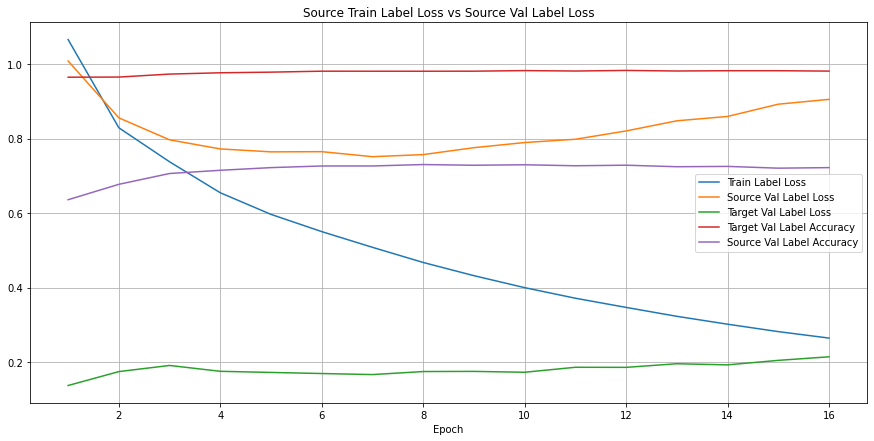

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

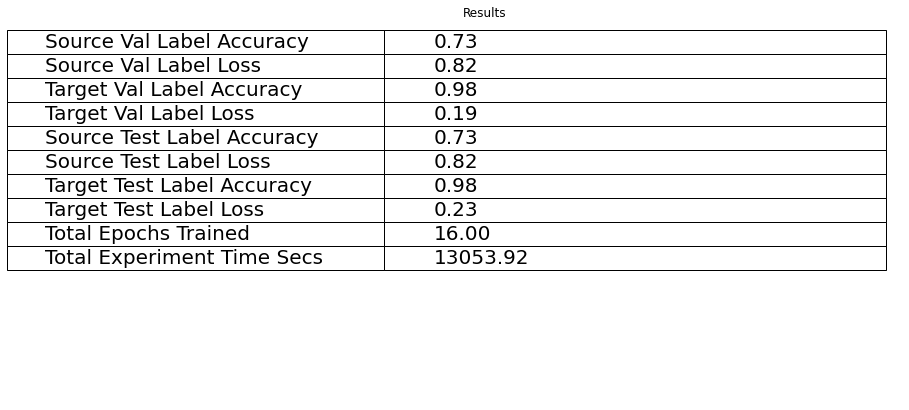

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

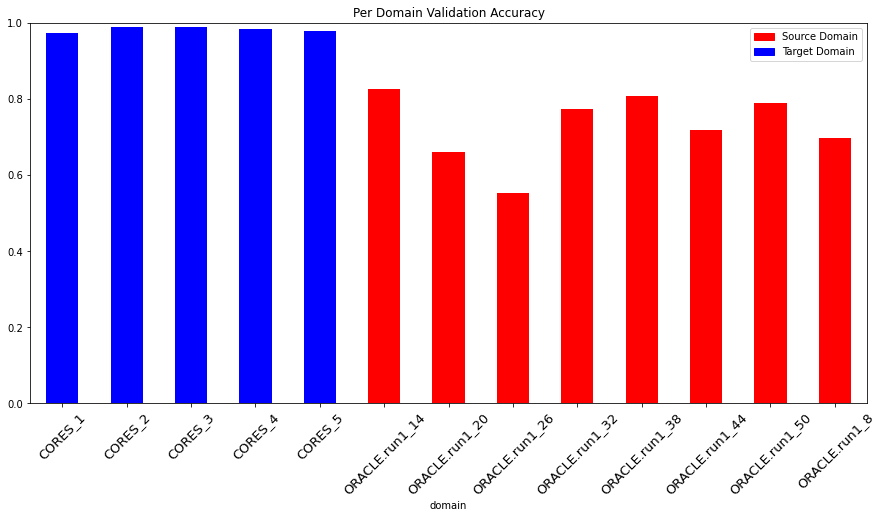

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.7300455729166667 Target Test Label Accuracy: 0.9818149717514124
Source Val Label Accuracy: 0.7284114583333333 Target Val Label Accuracy: 0.9827857142857143


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:cores-oracle.run1", "parameters": {"experiment_name": "tl_1v2:cores-oracle.run1", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}, {"class": "ReL